# IMPORT LIBRARIES

In [ ]:
!pip install -U yellowbrick

     |████████████████████████████████| 276kB 10.0MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

# For deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [ ]:
# FOR REPRODUCIBILITY
SEED = 51   # ALSO USED FOR THE RANDOM_STATE OF KMEANS()
tf.keras.backend.clear_session()      # CLEAR OUT JUNK FROM A PREVIOUS KERAS SESSION
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING DATA

### Data Source: https://www.kaggle.com/arjunbhasin2013/ccdata

##### CUSTID: Identification of Credit Card holder 
##### BALANCE: Balance amount left in customer's account to make purchases
##### BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
##### PURCHASES: Amount of purchases made from account
##### ONEOFFPURCHASES: Maximum purchase amount done in one-go
##### INSTALLMENTS_PURCHASES: Amount of purchase done in installment
##### CASH_ADVANCE: Cash in advance given by the user
##### PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
##### ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
##### PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
##### CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
##### CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
##### PURCHASES_TRX: Number of purchase transactions made
##### CREDIT_LIMIT: Limit of Credit Card for user
##### PAYMENTS: Amount of Payment done by user
##### MINIMUM_PAYMENTS: Minimum amount of payments made by user  
##### PRC_FULL_PAYMENT: Percent of full payment paid by user
##### TENURE: Tenure of credit card service for user

In [ ]:
df_credit = pd.read_csv('/content/drive/My Drive/Data_finance/4.+Marketing_data.csv')
df_credit

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [ ]:
# Mean balance is $1564 
# Balance frequency is frequently updated on average ~0.9
# Purchases average is $1000
# one off purchase average is ~$600
# Average purchases frequency is around 0.5
# average ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, and CASH_ADVANCE_FREQUENCY are generally low
# Average credit limit ~ 4500
# Percent of full payment is 15%
# Average tenure is 11 years
df_credit.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Let's look at some of the interesting cases. For example, the one with an one-off purchase of around $41,000 !

Or the one who made cash advance transactions of around $47,000 !

In [ ]:
# Let's see who made one off purchase of $40761!
df_credit[df_credit['ONEOFF_PURCHASES'] == df_credit['ONEOFF_PURCHASES'].max()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
550,C10574,11547.52001,1.0,49039.57,40761.25,8278.32,558.166886,1.0,1.0,0.916667,0.083333,1,101,22500.0,46930.59824,2974.069421,0.25,12


This customer has a high one-off purchase frequency as well as purchases frequency. Rarely uses the the cash advance option, which is good. 

In [ ]:
# Let's see who made cash advance of $47137!

df_credit[df_credit['CASH_ADVANCE'] == df_credit['CASH_ADVANCE'].max()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12


Insane amounts of cash advance transactions. And never made full_payments !

# EXPLORATORY ANALYSIS

In [ ]:
# Let's see if we have any missing data, we do have some...
df_credit.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Two variables have missing data. Let's see what percentage of the total do these correspond to...

In [ ]:
df_credit.isnull().mean()

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.000112
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    0.034972
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

'Mininmum payments' which has 133 missing points is only 3.5% of the overall data. So, we could do a simple mean/median imputation.

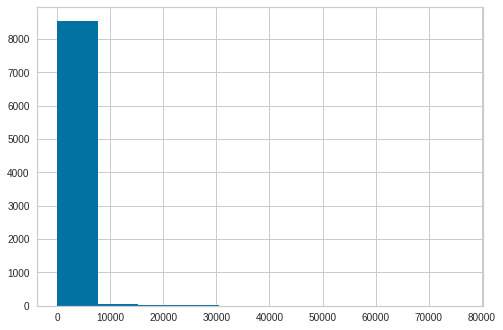

In [ ]:
df_credit['MINIMUM_PAYMENTS'].hist(bins=10)

It's heavily skewed to the left, so a median imputation then....

In [ ]:
# Fill up the missing elements with mean of the 'MINIMUM_PAYMENT' 
df_credit.loc[df_credit['MINIMUM_PAYMENTS'].isnull() == True, 'MINIMUM_PAYMENTS'] = df_credit['MINIMUM_PAYMENTS'].median()

In [ ]:
df_credit.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        1
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

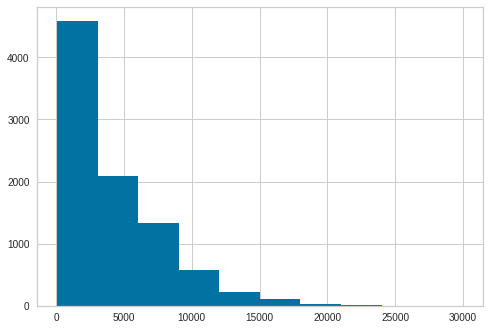

In [ ]:
df_credit['CREDIT_LIMIT'].hist(bins=10)

Again a median imputation...

In [ ]:
# Fill up the missing elements with mean of the 'CREDIT_LIMIT' 
df_credit.loc[df_credit['CREDIT_LIMIT'].isnull() == True, 'CREDIT_LIMIT'] = df_credit['CREDIT_LIMIT'].median()

In [ ]:
df_credit.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

Looks good now !

In [ ]:
# Let's see if we have duplicated entries in the data
df_credit.duplicated().sum()

0

In [ ]:
# Let's drop Customer ID since it has no meaning here 
df_credit.drop(columns=['CUST_ID'], inplace=True)

In [ ]:
df_credit.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


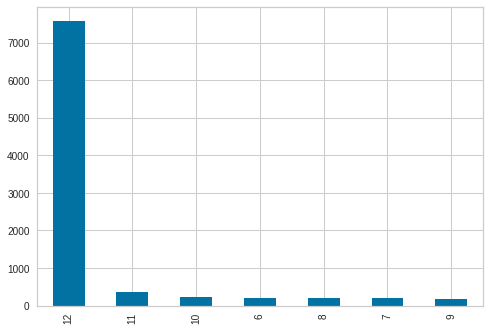

In [ ]:
df_credit['TENURE'].value_counts().plot.bar()

In [ ]:
df_credit['TENURE'].value_counts()/len(df_credit)

12    0.847374
11    0.040782
10    0.026369
6     0.022793
8     0.021899
7     0.021229
9     0.019553
Name: TENURE, dtype: float64

85% of the customers have a 12 year tenure. So most of them are old customers...

In [ ]:
num_columns = len(df_credit.columns)
num_columns

17

In [ ]:
df_credit.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

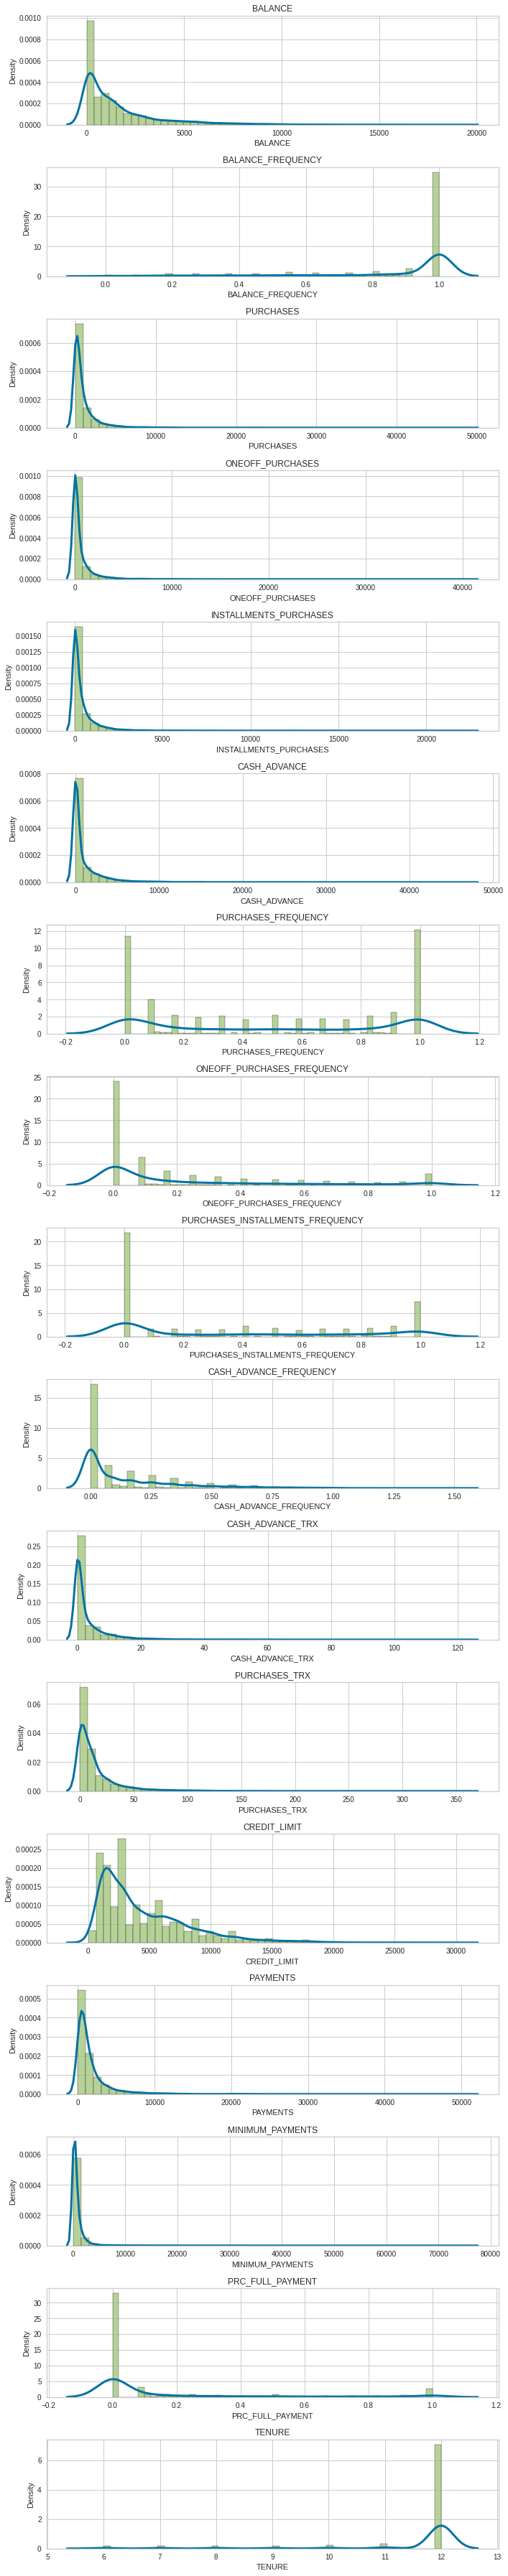

In [ ]:
# Combining a histplot with a kde plot. What do we learn??
# Mean of balance is $1500
# 'Balance_Frequency' for most customers is updated frequently ~1
# For 'PURCHASES_FREQUENCY', there are two distinct group of customers
# For 'ONEOFF_PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY' most users don't do one off puchases or installment purchases frequently 
# Very small number of customers pay their balance in full 'PRC_FULL_PAYMENT'~0
# Credit limit average is around $4500
# Most customers are ~11 years tenure

plt.figure(figsize=(10,50))
for i in range(num_columns):
    plt.subplot(17, 1, i+1)
    sns.histplot(data = df_credit, x = df_credit.columns[i], color='g', bins = 50, stat = 'density')
    sns.kdeplot(data = df_credit, x = df_credit.columns[i], color = 'b', lw = 3)
    plt.title(df_credit.columns[i])
plt.tight_layout()

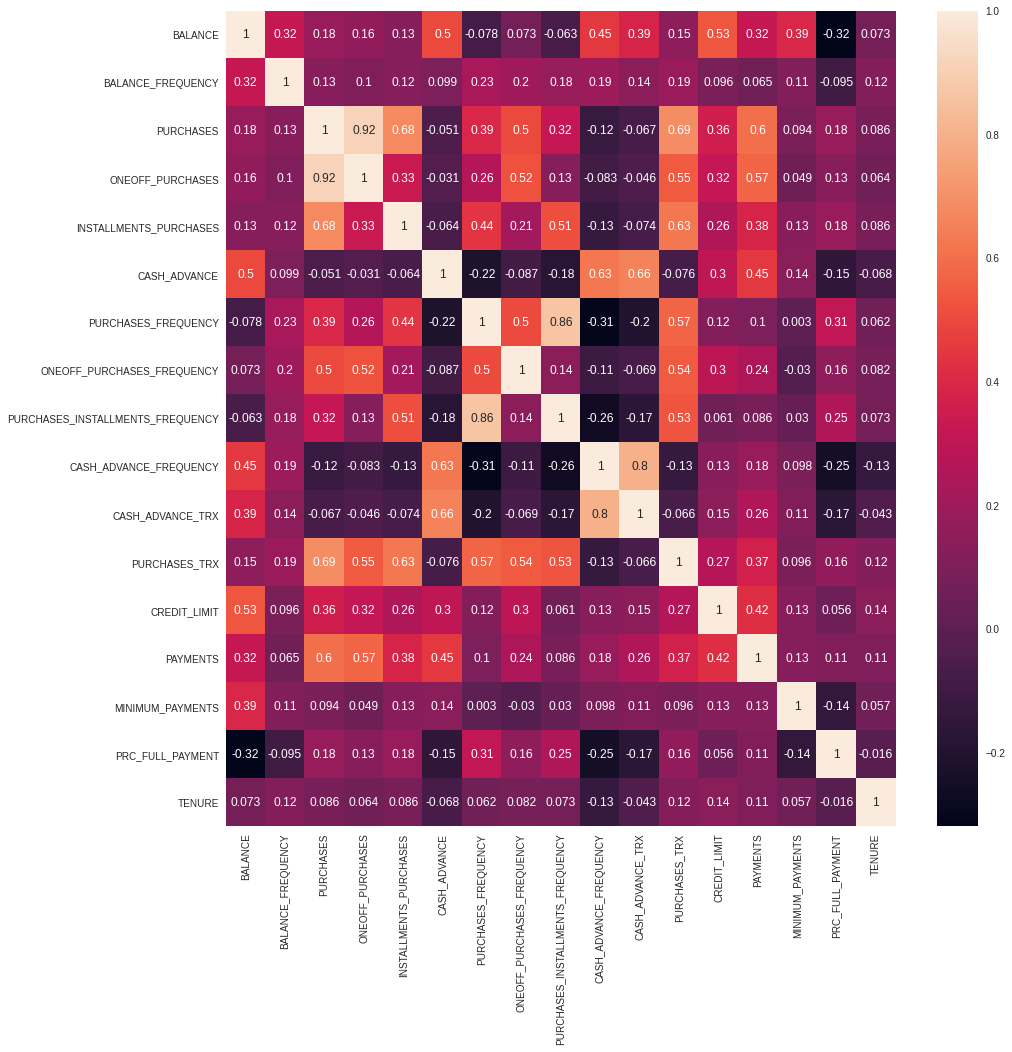

In [ ]:
# 'PURCHASES' have high correlation between one-off purchases, 'installment purchases, purchase transactions, credit limit and payments. 
# Strong Positive Correlation between 'PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY'
plt.figure(figsize=(15,15))
sns.heatmap(df_credit.corr(), annot=True)

# ELBOW METHOD TO DECIDE ON NUMBER OF CLUSTERS

In [ ]:
# Let's scale the data first
scaler = StandardScaler()
df_credit_scaled = scaler.fit_transform(df_credit)

In [ ]:
df_credit_scaled

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.31096755,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08931021,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.10166318,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.33546549,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34690648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.33294642,
        -0.52555097, -4.12276757]])

In [ ]:
# Finding the WCSS for a range of cluster sizes to find the elbow
scores = [KMeans(i).fit(df_credit_scaled).inertia_ for i in range(1,20)]

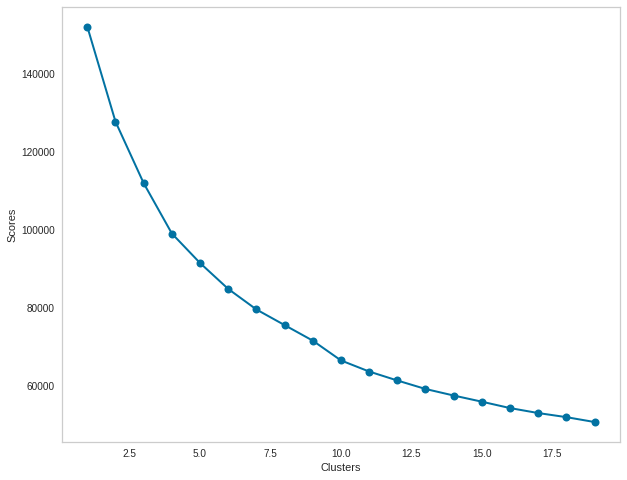

In [ ]:
# The decrease in WCSS seems to saturate within a cluster size of 6-8. 
plt.figure(figsize=(10,8))
plt.plot(range(1,20), scores, '-ob', linewidth = 2, markersize=8)
plt.xlabel('Clusters')
plt.ylabel('Scores')
plt.grid()

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2833ae9e8>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

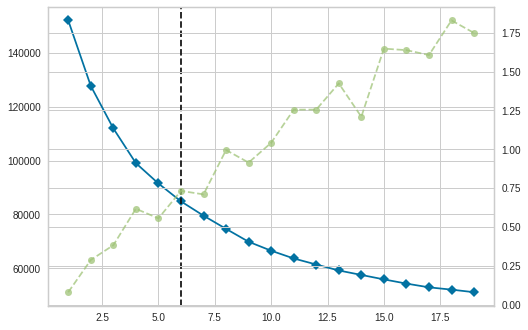

In [ ]:
# Let's confirm this with KElbowVisualizer
model = KElbowVisualizer(KMeans(random_state = SEED), k=(1,20))
model.fit(df_credit_scaled)

In [ ]:
model.elbow_value_

6

# APPLY K-MEANS METHOD

In [ ]:
# obtained n = 6 from the Elbow method
num_clusters = 6

In [ ]:
kmeans_model = KMeans(n_clusters = num_clusters, random_state=SEED)
kmeans_model.fit(df_credit_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=51, tol=0.0001, verbose=0)

In [ ]:
labels = kmeans_model.labels_
labels

array([4, 5, 3, ..., 2, 4, 4], dtype=int32)

In [ ]:
kmeans_model.cluster_centers_.shape

(6, 17)

In [ ]:
cluster_centers = pd.DataFrame(data = kmeans_model.cluster_centers_, columns = list(df_credit.columns))        
cluster_centers

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.697844,-2.121553,-0.313038,-0.231015,-0.315659,-0.306912,-0.560037,-0.418705,-0.465064,-0.484403,-0.357813,-0.425746,-0.209329,-0.221025,-0.256015,0.261571,-0.165980
1,1.443847,0.414656,7.093187,6.244031,5.297641,0.004274,1.081960,1.867817,1.035380,-0.299540,-0.116878,4.699112,2.171463,4.847281,1.104788,0.830765,0.333341
2,-0.396865,0.308323,-0.067365,-0.244767,0.290363,-0.365854,0.964682,-0.376324,1.139229,-0.463438,-0.358105,0.122143,-0.329833,-0.251488,-0.056038,0.340692,-0.025166
3,0.137676,0.427207,0.926437,0.877387,0.578596,-0.309096,1.087856,1.838892,0.542908,-0.405671,-0.318458,1.184038,0.692399,0.380207,-0.024143,0.435885,0.271440
4,-0.010281,0.372121,-0.345349,-0.223850,-0.405221,-0.081714,-0.826548,-0.335680,-0.770855,0.131981,-0.028270,-0.470705,-0.332477,-0.262070,-0.029880,-0.451012,-0.008641
5,1.591479,0.376997,-0.204185,-0.148783,-0.209546,1.949748,-0.449498,-0.183691,-0.406362,1.901136,1.855405,-0.244017,0.963871,0.776815,0.512337,-0.391139,-0.089840


In [ ]:
# In order to understand what these numbers mean, let's perform inverse transformation

cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = list(df_credit.columns))
cluster_centers

# First Customers cluster (Transactors : CL-0): Those are customers who pay least amount of intrerest charges and careful with their money, Cluster with lowest balance ($104) and cash advance ($303), Percentage of full payment = 23%
# Second customers cluster (revolvers : CL-5) who use credit card as a loan (most lucrative sector): highest balance ($5000) and cash advance (~$5000), low purchase frequency, high cash advance frequency (0.5), high cash advance transactions (16) and low percentage of full payment (3%)
# Third customer cluster (VIP/Prime : CL-1): high credit limit $12K and highest percentage of full payment, target for increase credit limit and increase spending habits
# Fourth customer cluster (Frequent purchasers : CL-3) : highest purchase (and one-off purchase) and balance frequency (NOT REALLY??).

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,111.971653,0.374694,334.395004,209.000465,125.620931,335.263311,0.265580,0.077550,0.179609,0.038210,0.807018,4.127384,3732.825243,1093.299450,267.574608,0.230220,11.295195
1,4569.720859,0.975499,16157.907683,10956.249146,5201.658537,987.833746,0.924593,0.759664,0.775924,0.075203,2.451220,131.512195,12395.121951,15765.548522,3438.869446,0.396699,11.963415
2,738.433679,0.950310,859.277602,186.173496,673.638969,211.658792,0.877524,0.090193,0.817196,0.042405,0.805020,17.745854,3294.383775,1005.110526,733.613272,0.253361,11.483640
3,1851.036530,0.978472,2982.551670,2048.720612,934.284573,330.682005,0.926960,0.751035,0.580203,0.053965,1.075586,44.140590,7013.678967,2833.805467,807.943042,0.281204,11.880574
4,1543.075446,0.965423,265.361154,220.892134,44.631756,807.512306,0.158617,0.102318,0.058080,0.161555,3.055903,3.009865,3284.763784,974.478117,794.572431,0.021801,11.505755
5,4877.004640,0.966578,566.960000,345.487536,221.578150,5067.584105,0.309945,0.147659,0.202939,0.515581,15.910603,8.644491,8001.408051,3981.946723,2058.187456,0.039313,11.397089


In [ ]:
# concatenate the clusters labels to our original dataframe

df_credit_clusters = pd.concat([df_credit, pd.DataFrame(labels, columns=['cluster'])], axis = 1)
df_credit_clusters

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,4
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,5
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,4
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6,2
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,864.206542,0.000000,6,2
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6,2
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6,4


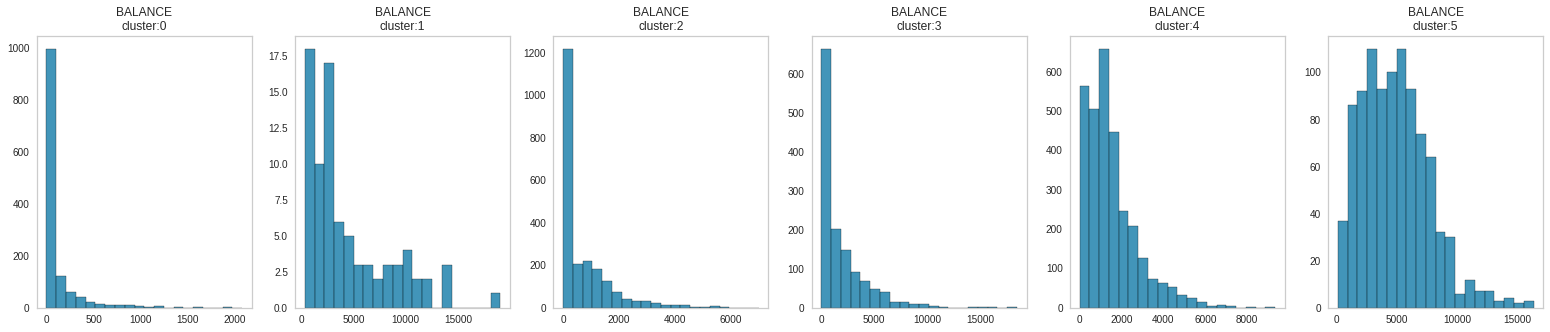

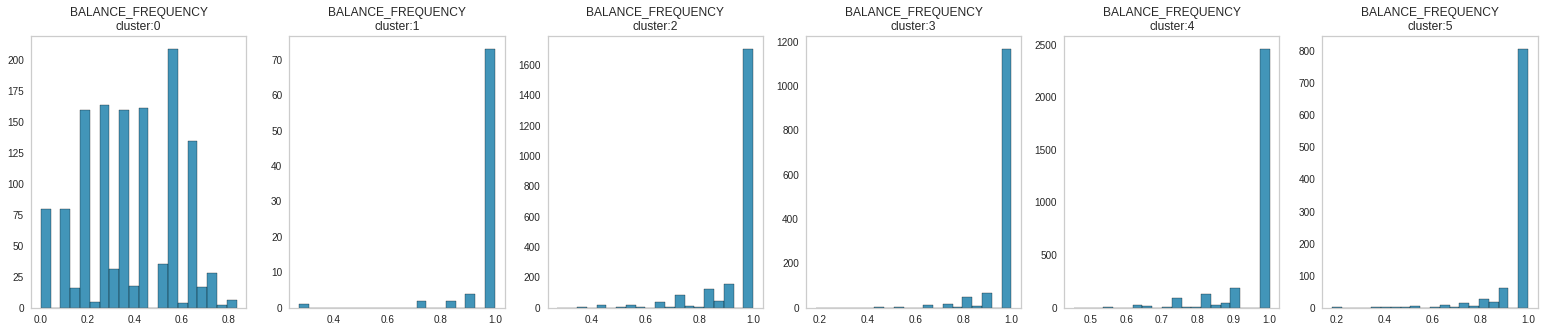

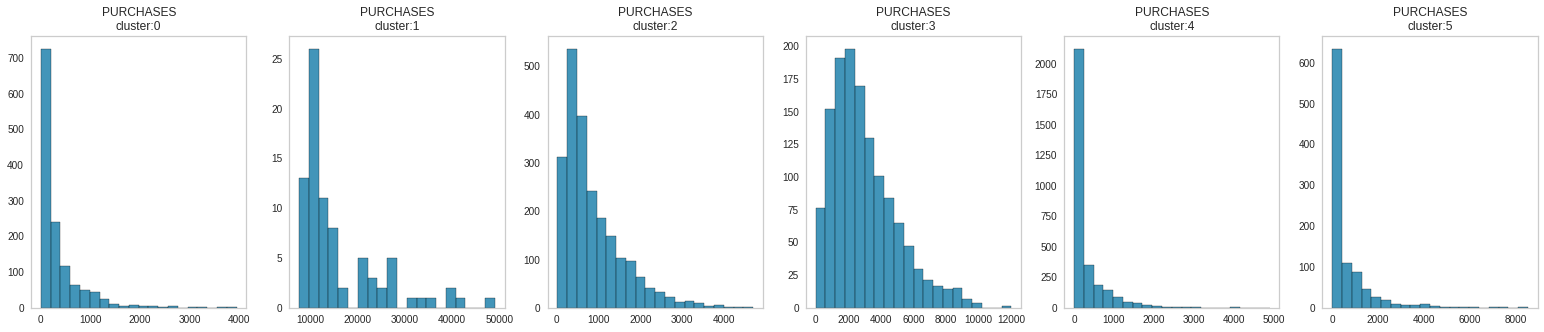

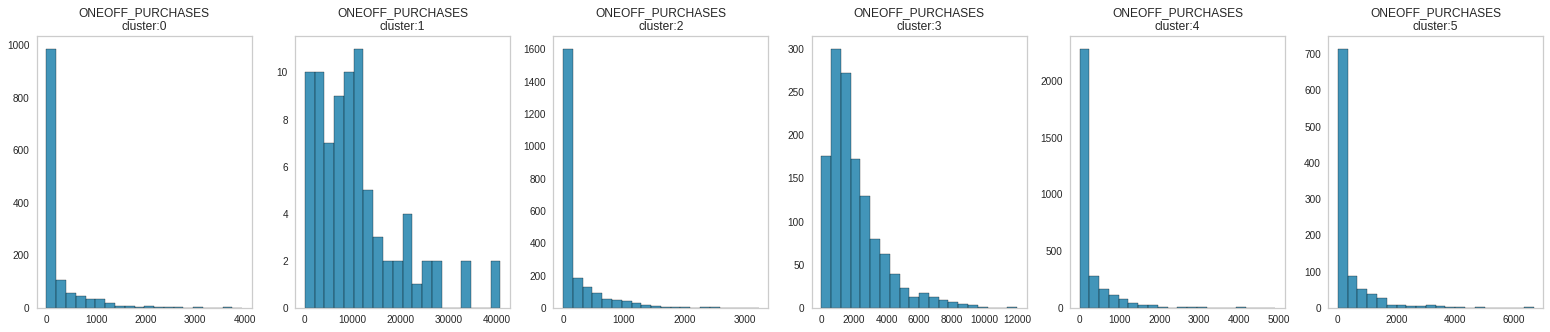

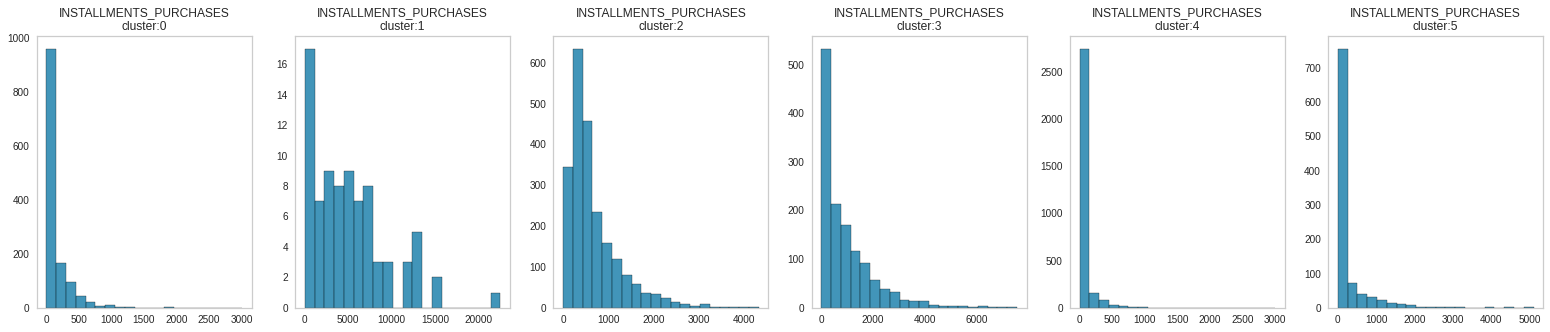

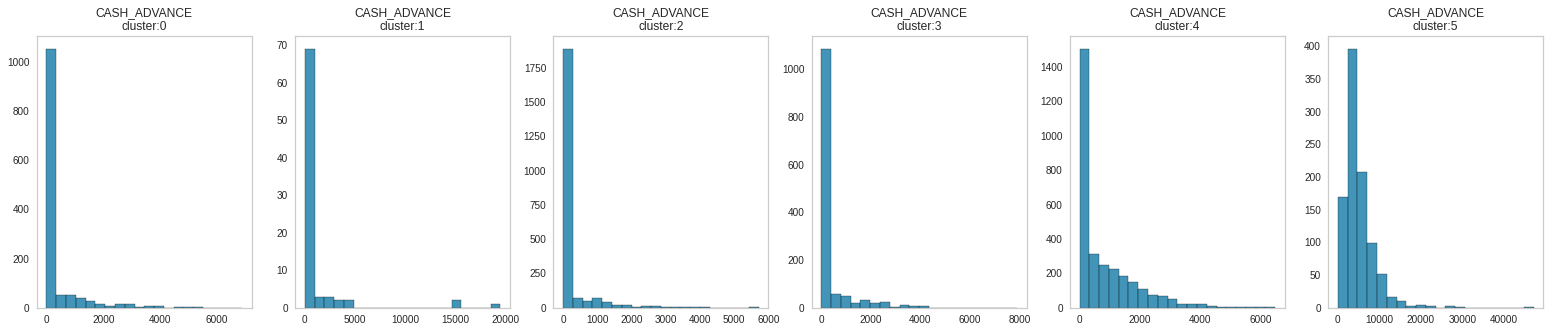

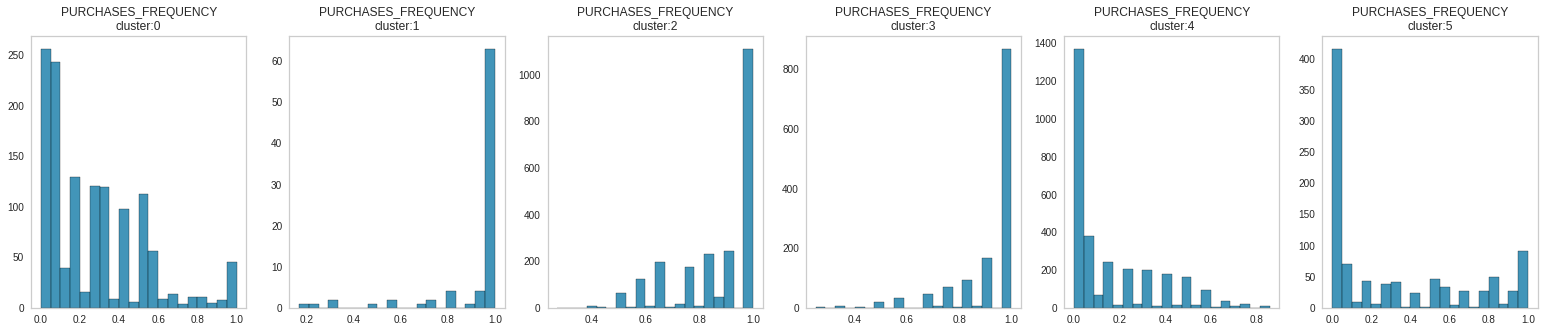

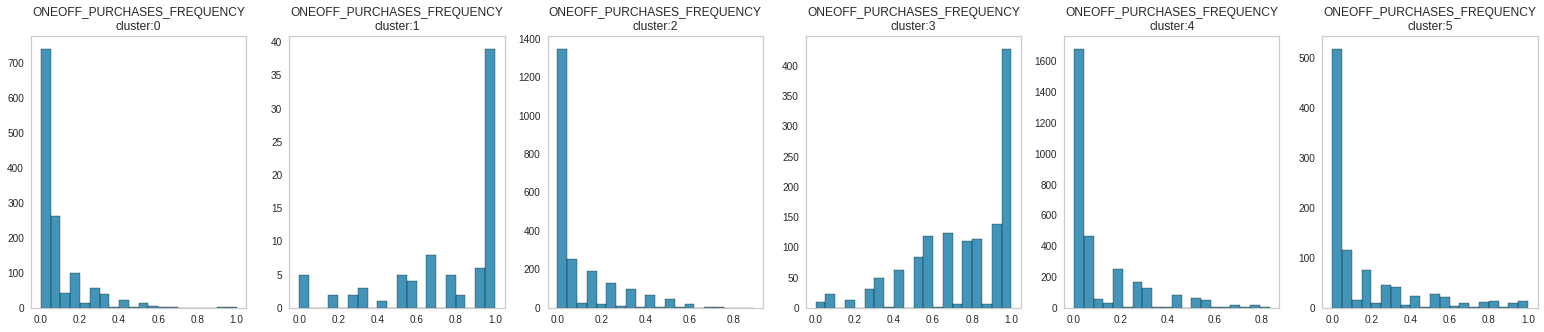

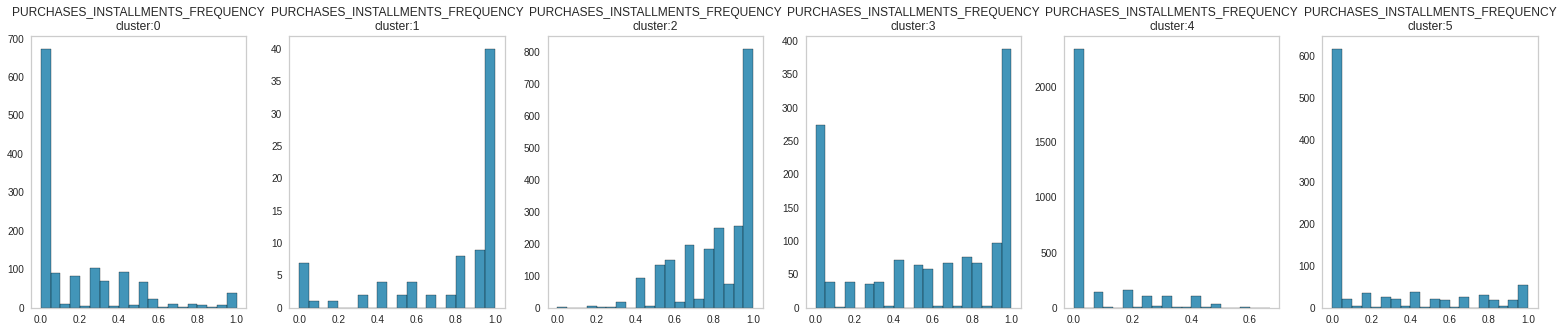

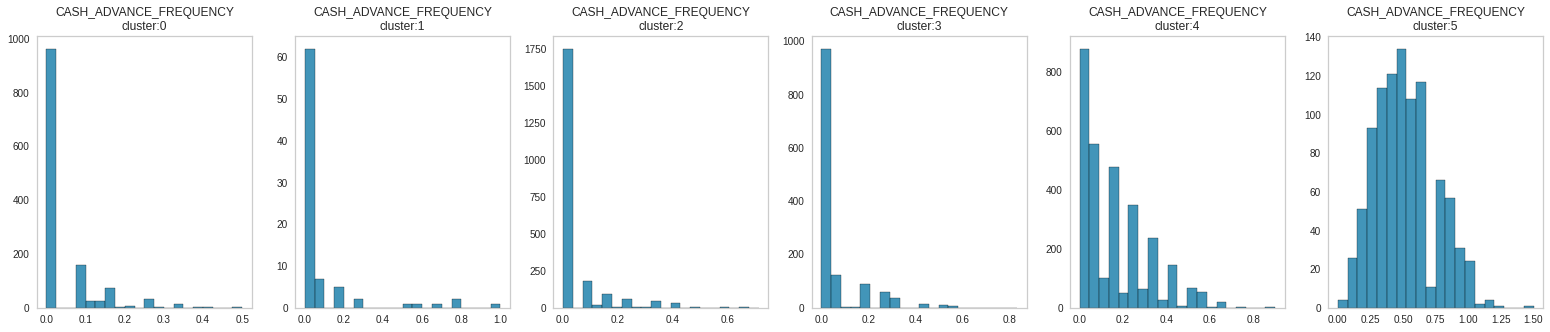

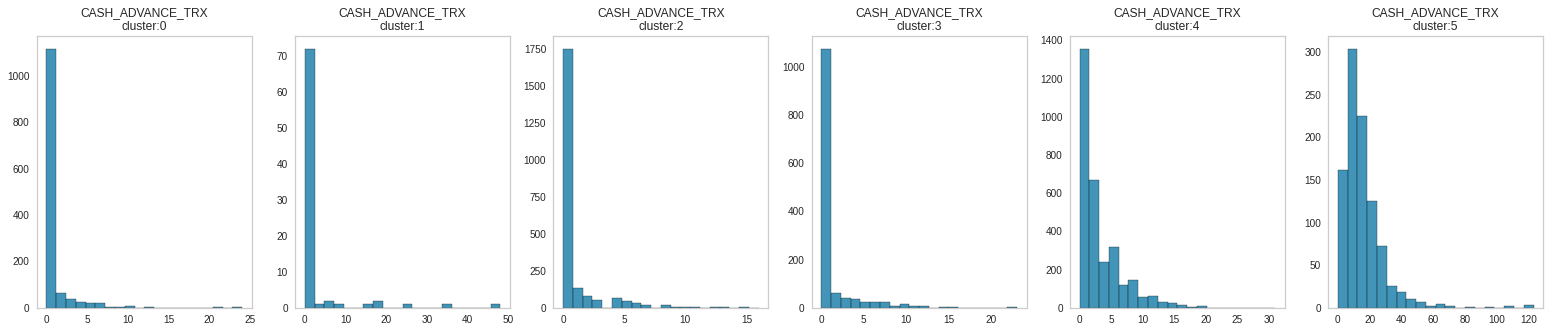

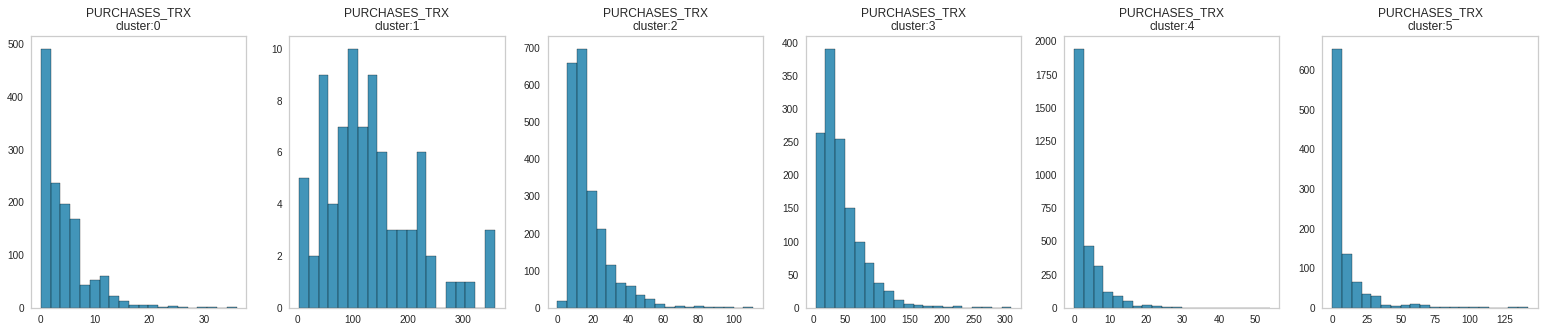

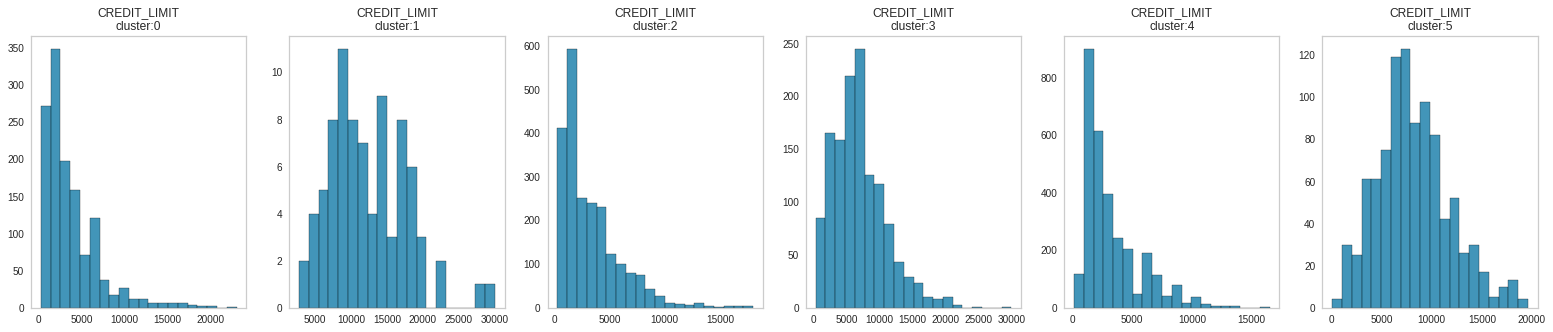

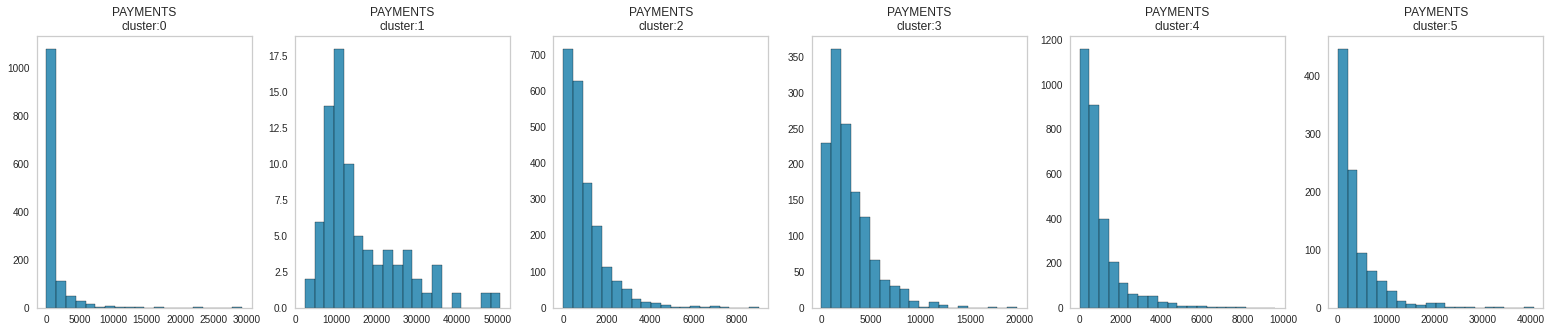

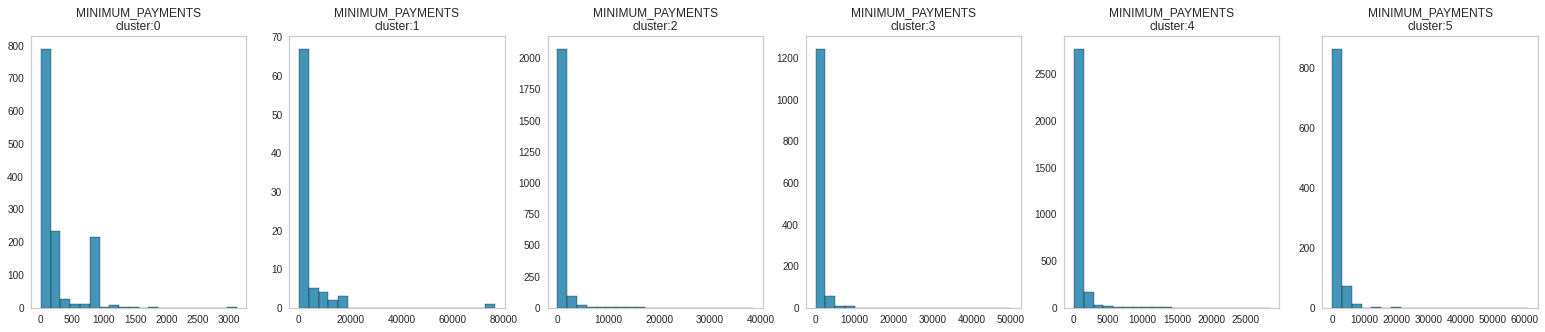

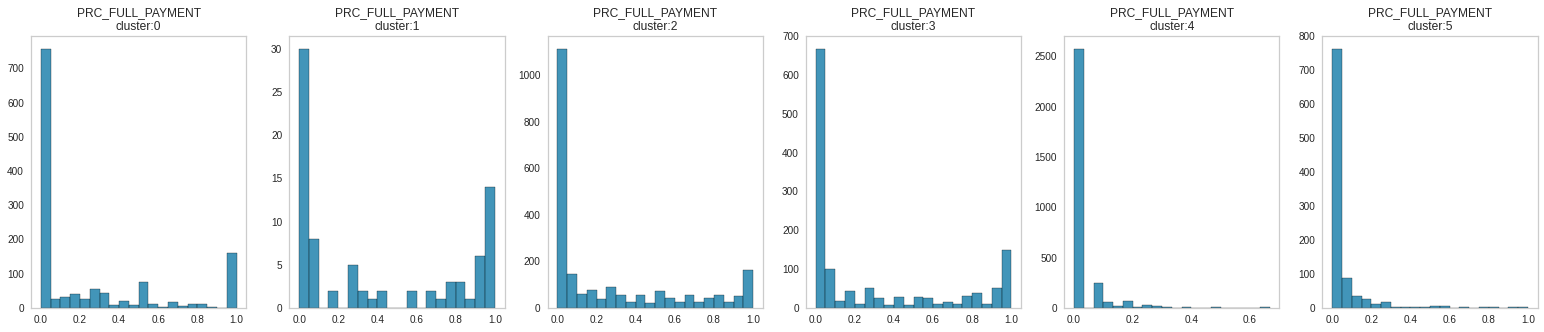

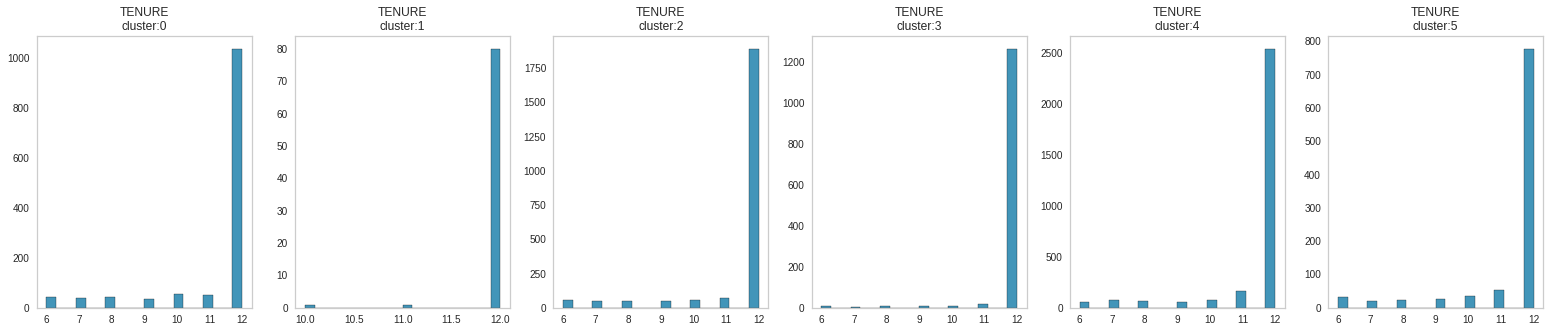

In [ ]:
# Could use either seaborn or pandas hist---
for k, i in enumerate(df_credit.columns):
    plt.figure(figsize = (num_clusters*4.5, 5))
    for j in range(num_clusters):
        plt.subplot(1, num_clusters, j+1)
        sns.histplot(data = df_credit_clusters[df_credit_clusters['cluster'] == j], x = i, bins = 20)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid()
        plt.title(f"{i}\ncluster:{j}")
    plt.show()

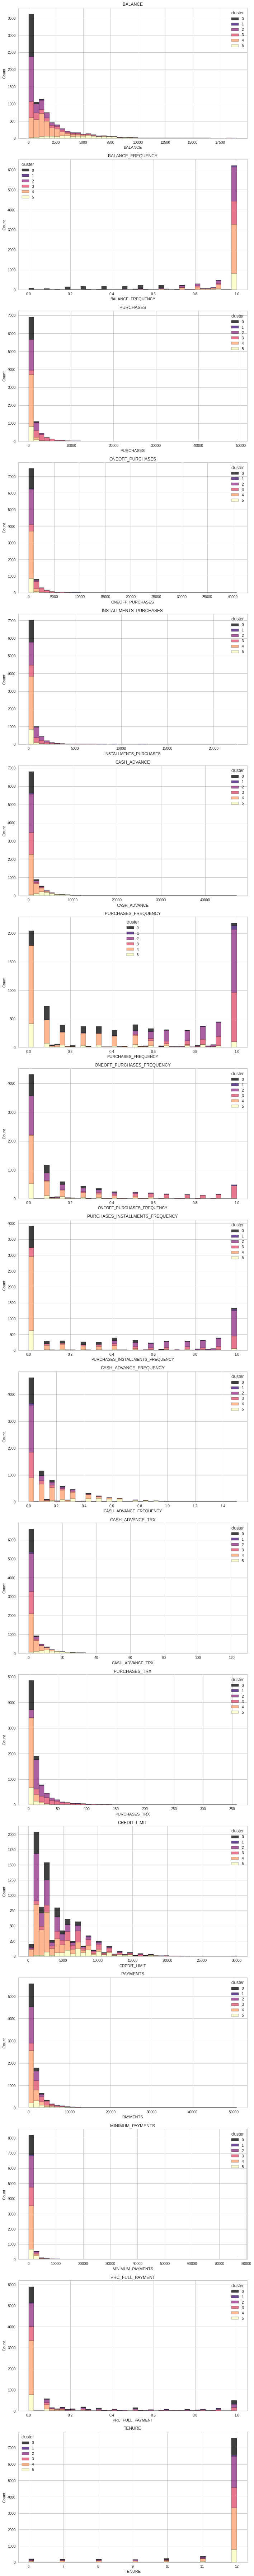

In [ ]:
plt.figure(figsize=(10,100))
for i in range(num_columns):
    plt.subplot(17, 1, i+1)
    sns.histplot(data = df_credit_clusters, x = df_credit.columns[i], hue = 'cluster', multiple = 'stack', palette = sns.color_palette("magma", as_cmap=True),bins = 40)
    #sns.kdeplot(data = df_credit, x = df_credit.columns[i], color = 'b', lw = 3)
    plt.title(df_credit.columns[i])
plt.tight_layout()

### Few of the predicitve properties are : 

#### BALANCE
#### CASH ADVANCE
#### CREDIT LIMIT
#### PURCHASE FREQUENCY
#### PRC FULL PAYMENT
#### PURCHASES

Maybe plot a seaborn pairplot for a few of the predictive properties.......

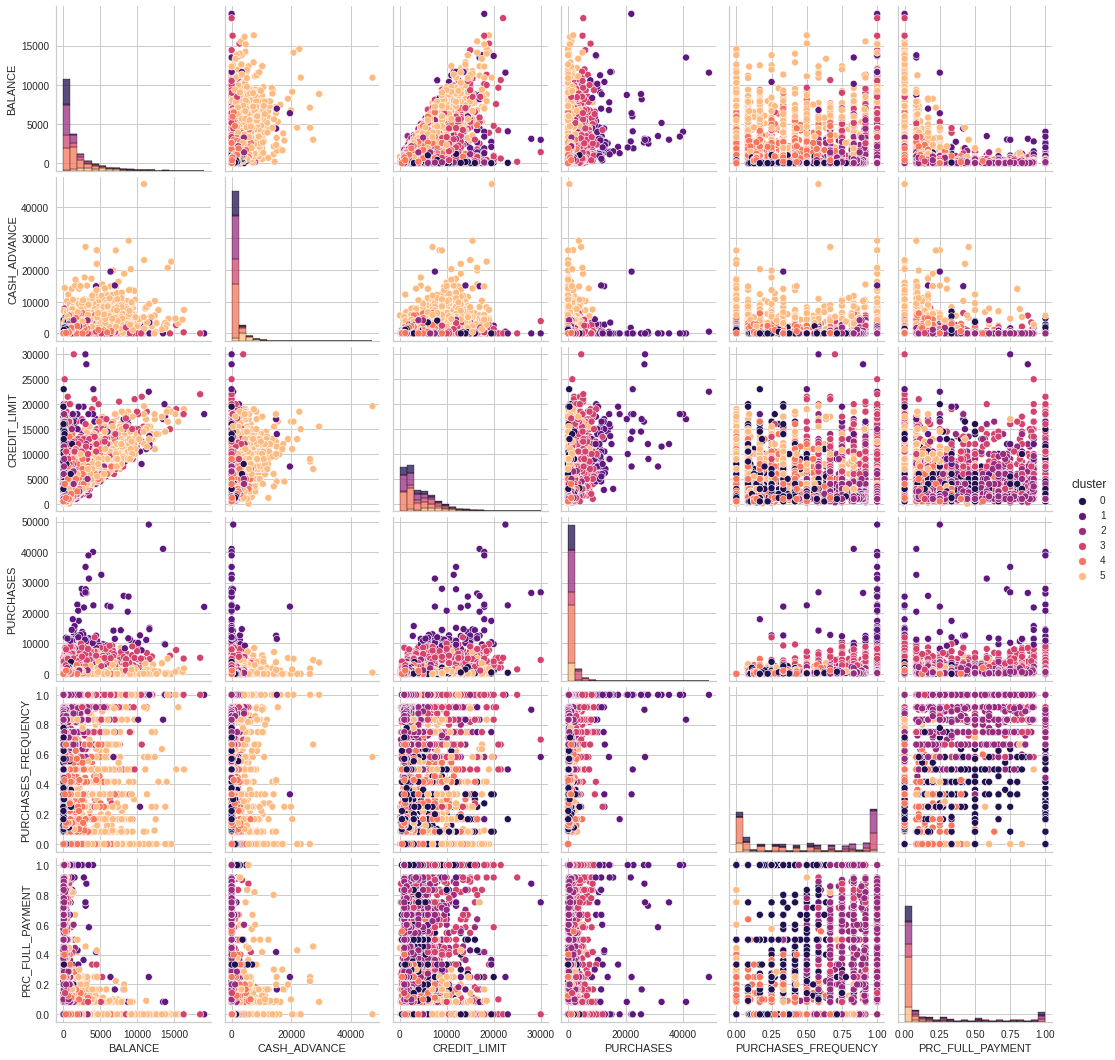

In [ ]:
columns_to_keep = ['BALANCE', 'CASH_ADVANCE','CREDIT_LIMIT', 'PURCHASES', 'PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'cluster']
sns.pairplot( df_credit_clusters[columns_to_keep], hue="cluster", diag_kind="hist", diag_kws={'multiple' : 'stack', 'bins': 20}, palette = sns.color_palette("magma"))

Not quite informative !

# PRINCIPAL COMPONENT ANALYSIS 




In [ ]:
# Obtain the principal components 
pca = PCA(n_components=2, random_state=SEED)
principal_comp = pca.fit_transform(df_credit_scaled)
principal_comp

array([[-1.68222052, -1.0764532 ],
       [-1.13828483,  2.50645088],
       [ 0.96967549, -0.38349741],
       ...,
       [-0.9262068 , -1.81078244],
       [-2.33655189, -0.65796829],
       [-0.55642058, -0.40046315]])

In [ ]:
# Create a dataframe with the two components
pca_df_1 = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df_1.head()

,pca1,pca2
0,-1.682221,-1.076453
1,-1.138285,2.506451
2,0.969675,-0.383497
3,-0.873630,0.043169
4,-1.599434,-0.688584


In [ ]:
# Concatenate the clusters labels to the dataframe
pca_df_1 = pd.concat([pca_df_1,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df_1.head()

,pca1,pca2,cluster
0,-1.682221,-1.076453,4
1,-1.138285,2.506451,5
2,0.969675,-0.383497,3
3,-0.873630,0.043169,4
4,-1.599434,-0.688584,4


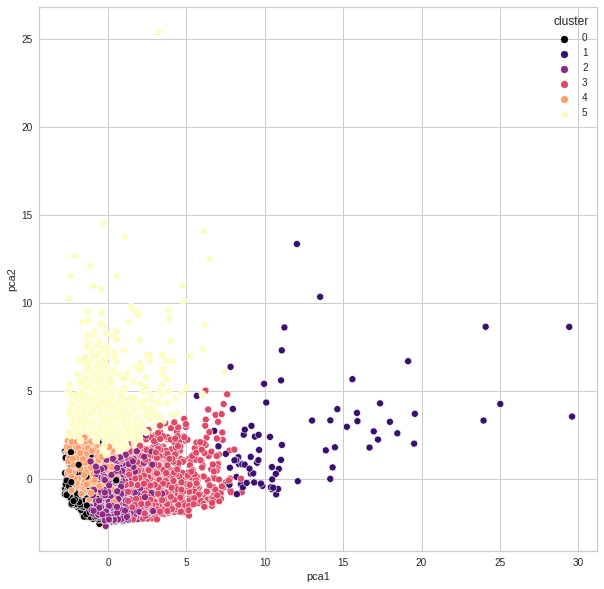

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df_1, palette =sns.color_palette("magma", as_cmap=True))
plt.show()

# AUTOENCODERS AS A DIMENSIONALITY REDUCTION TECHNIQUE

In [ ]:
from keras import regularizers

input_df = Input(shape=(17,))


#x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(256, activation='relu')(input_df)
#x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Now lets see the encoded version of our dataset
encoded = Dense(10, activation='relu', activity_regularizer=regularizers.l1(10e-6))(x)

x = Dense(128, activation='relu')(encoded)
#x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)

decoded = Dense(17)(x)

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mse')


In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 17)                4369  

In [ ]:
history = autoencoder.fit(df_credit_scaled, df_credit_scaled, batch_size = 128, epochs = 100,  verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 5ms/step - loss: 0.6401
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 0.1342
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0561
Epoch 4/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0240
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0232
Epoch 10/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0208
Epoch 11/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 12/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0215
Epoch 13/100
70/70 [=================

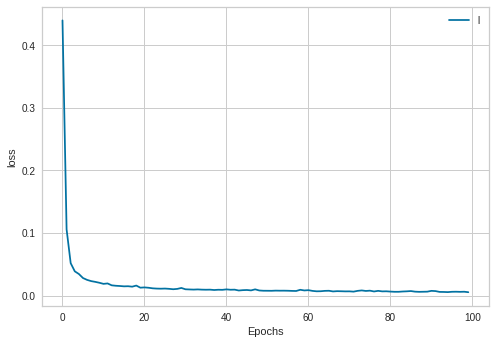

In [ ]:
#import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(string)
  plt.show()

plot_graphs(history, 'loss')

In [ ]:
# Now lets see the encoded version of our dataset
pred = encoder.predict(df_credit_scaled)

In [ ]:
pred.shape

(8950, 10)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa27f9ad6d8>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

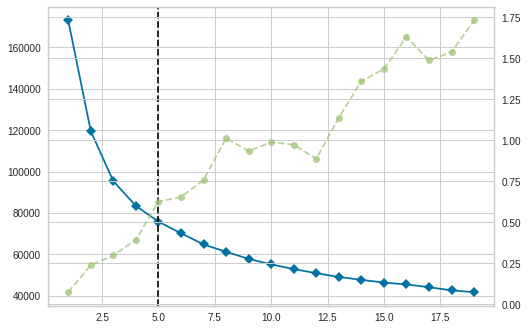

In [ ]:
model = KElbowVisualizer(KMeans(random_state=SEED), k=(1,20))
model.fit(pred)

In [ ]:
model.elbow_value_

5

In [ ]:
n_cluster = model.elbow_value_
kmeans = KMeans(n_clusters = n_cluster, random_state=SEED)
kmeans.fit(pred)
labels = kmeans.labels_

In [ ]:
df_cluster_autoencoded = pd.concat([df_credit, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_autoencoded.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,2
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [ ]:
df_cluster_autoencoded.loc[df_cluster_autoencoded['cluster'] == 0, 'CASH_ADVANCE_FREQUENCY'].mean()

0.11729233629352612

In [ ]:
df_cluster_autoencoded.loc[df_cluster_autoencoded['cluster'] == 3, 'CREDIT_LIMIT'].mean()

9658.563535911602

In [ ]:
df_cluster_autoencoded.loc[df_cluster_autoencoded['cluster'] == 1, 'PRC_FULL_PAYMENT'].mean()

0.035393013169446895

#### Cluster 4 : Highest mean credit limit (~13000) ---(then 3, 1)
#### Cluster 2 : Lowest balance (\~680) and cash advance (\~131) with negligible cash advance  ---(then 0)
#### Cluster 1 : Lowest full payment mean (~0.035). High cash advance TRX (next to cluster 4). Highest cash advance frequency
#### Cluster 0 : Similar to Cluster 2 but its at the other end of the spectrum when it comes to purchase frequency. So, in addition to the features of Cluster 2, this is charcterized by negligible purchase TRX/frequency

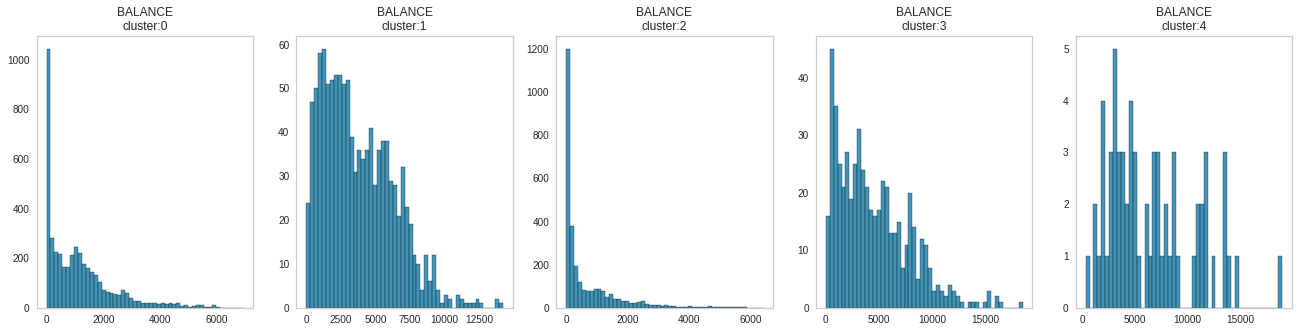

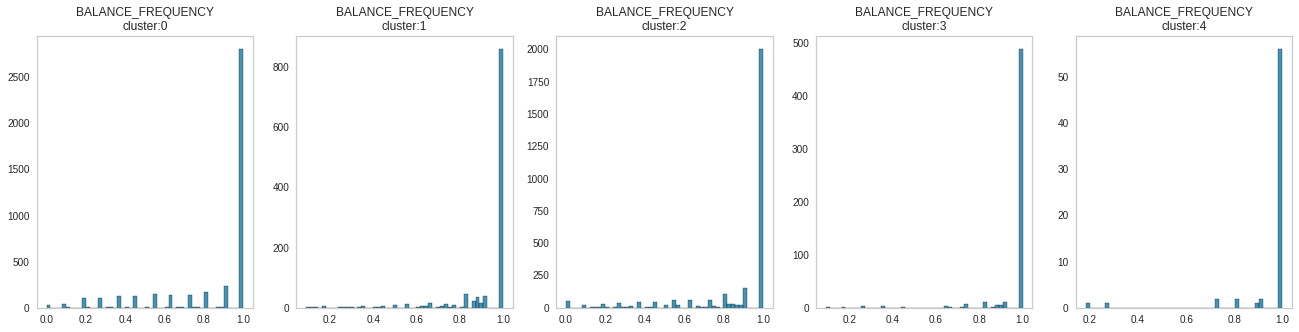

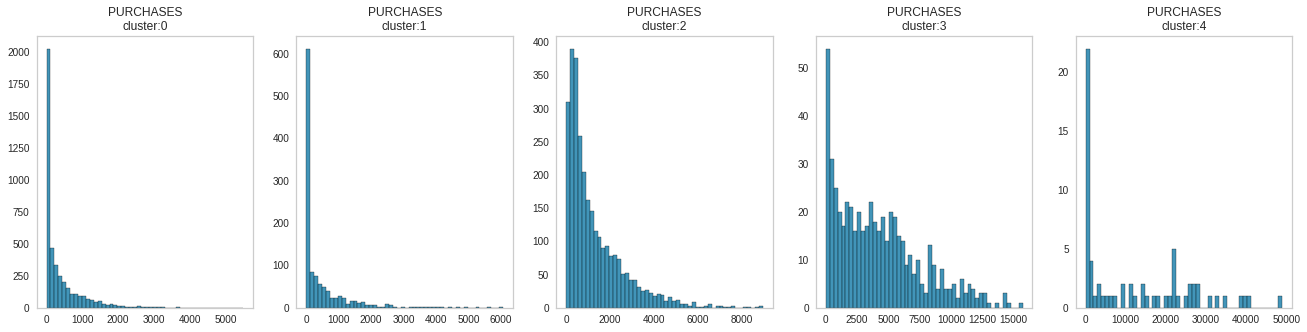

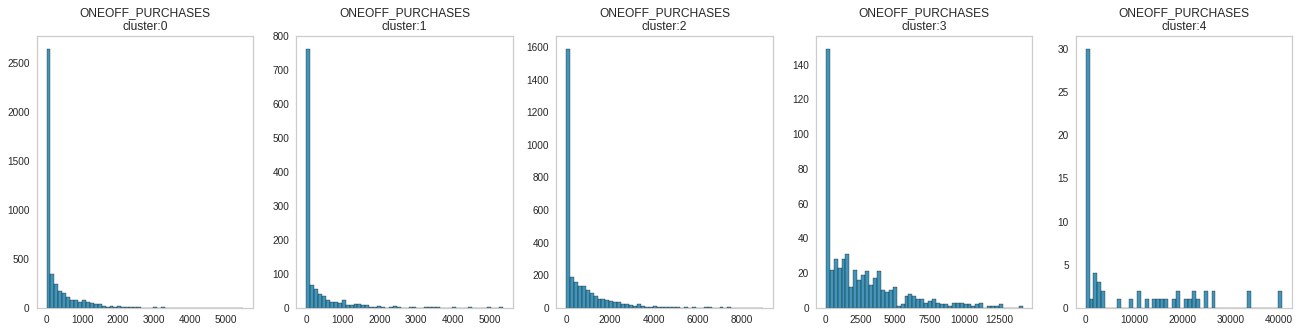

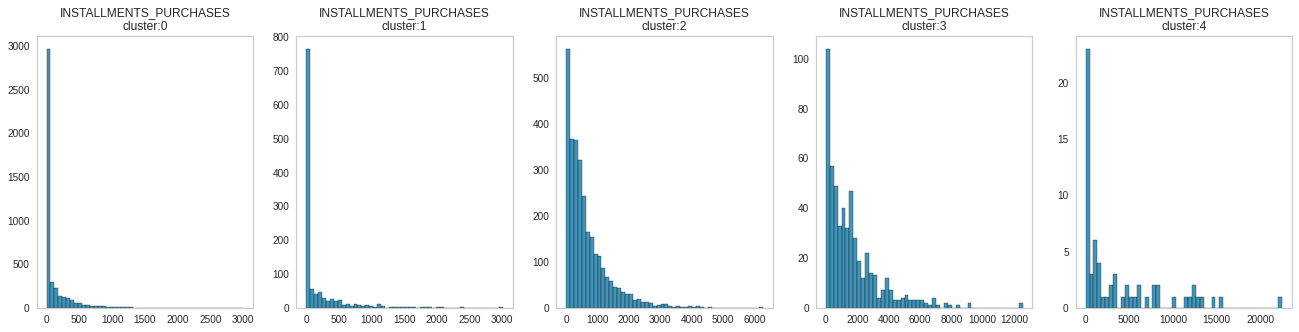

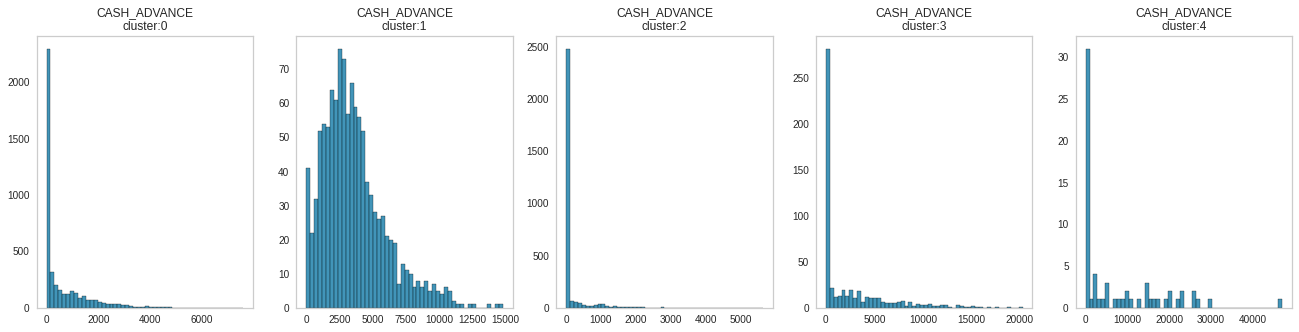

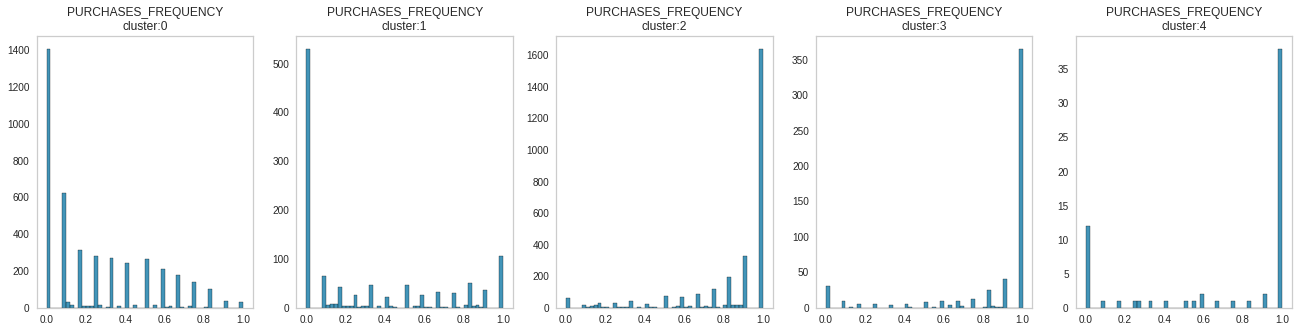

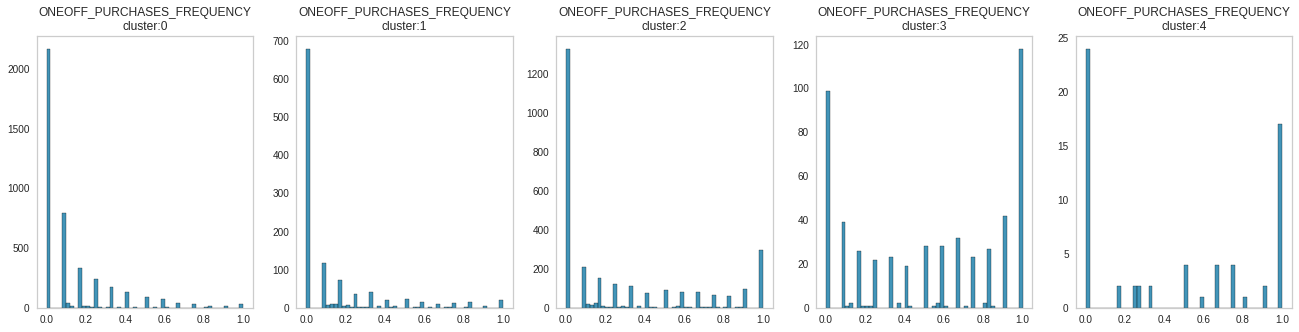

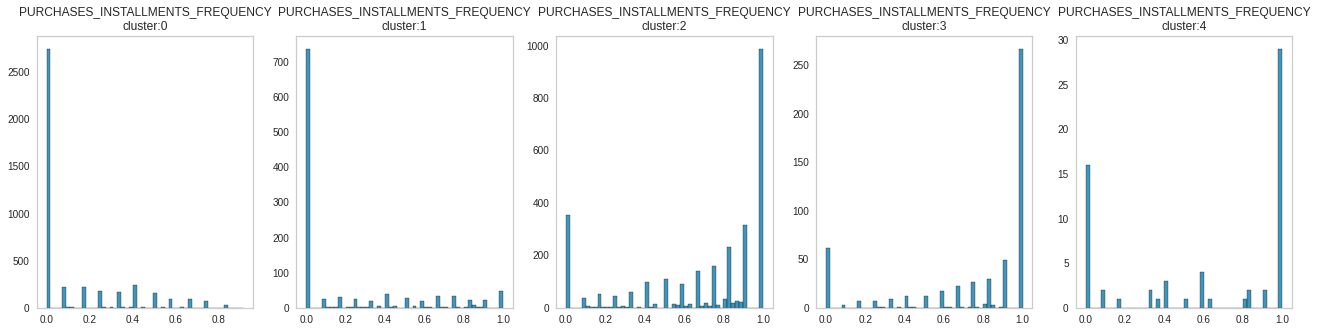

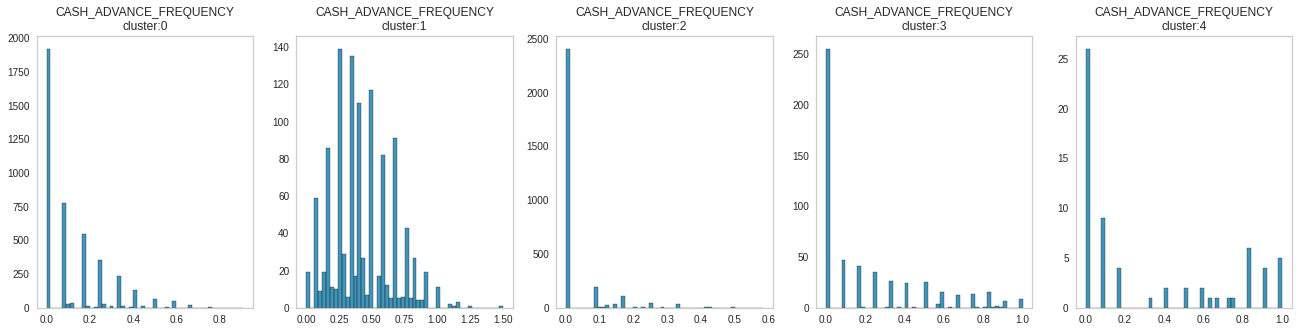

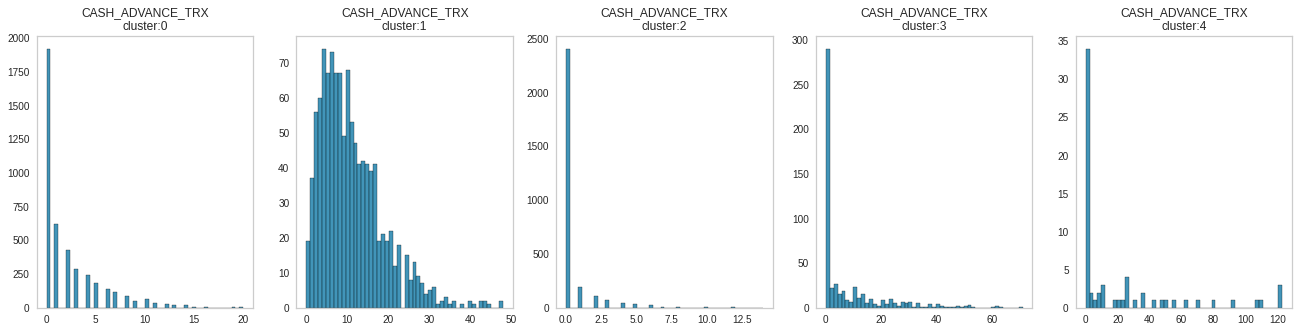

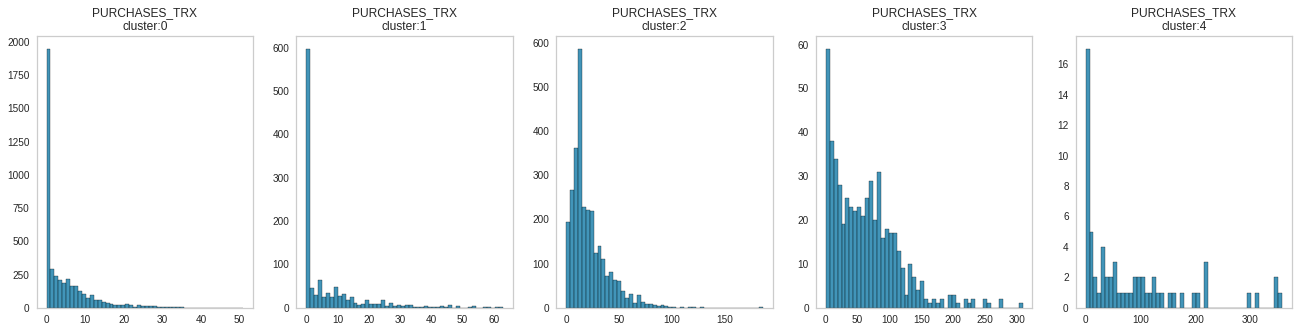

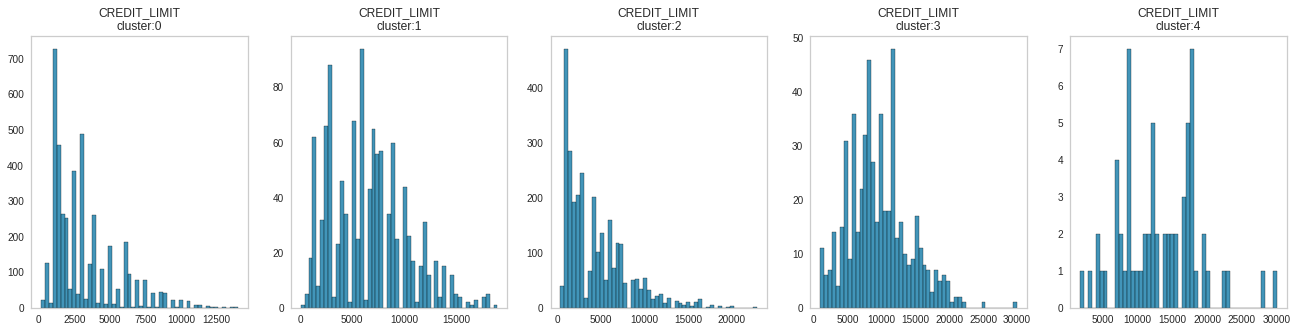

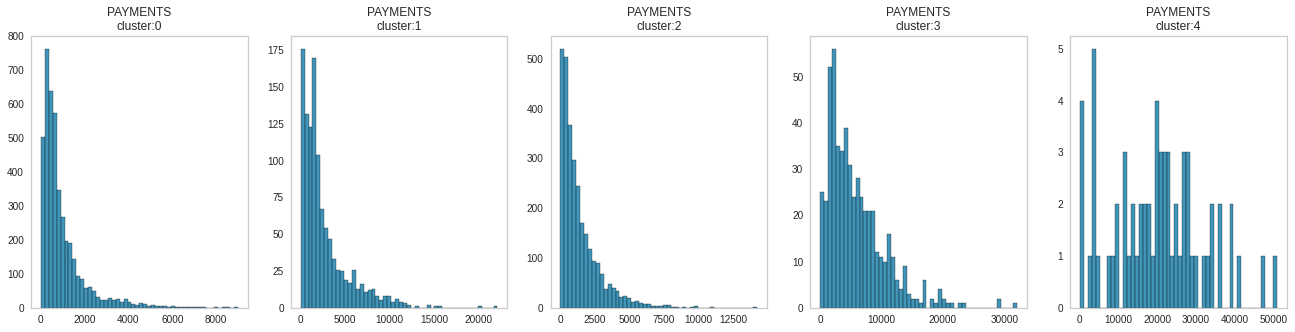

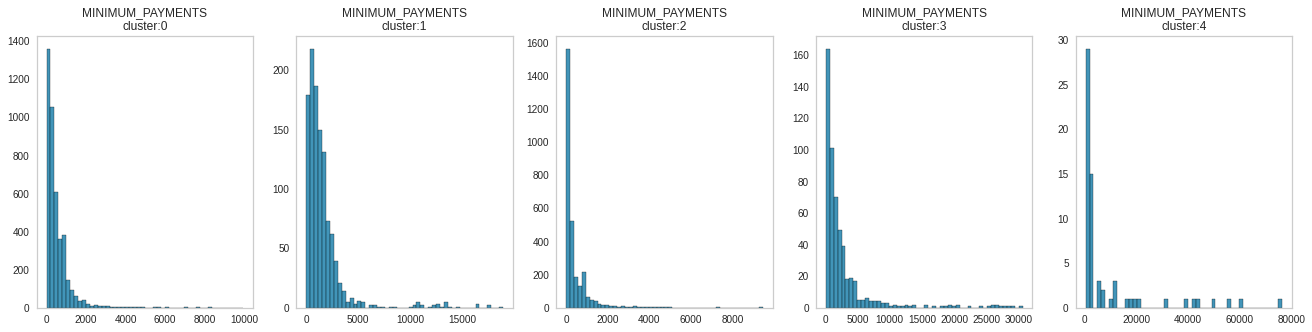

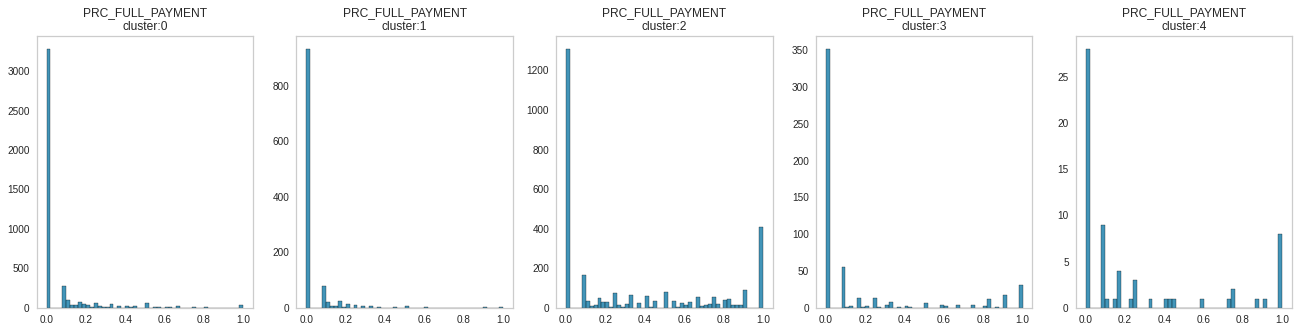

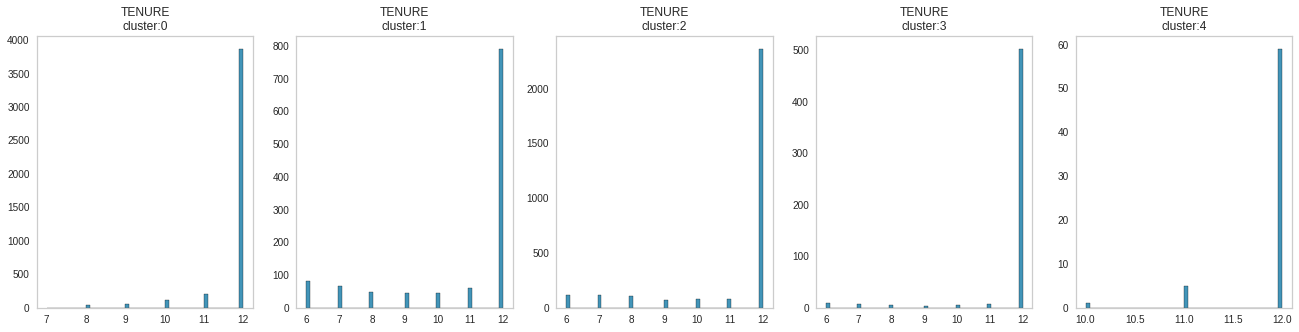

In [ ]:
for k, i in enumerate(df_credit.columns):
    plt.figure(figsize = (n_cluster*4.5, 5))
    for j in range(n_cluster):
        plt.subplot(1, n_cluster, j+1)
        sns.histplot(data = df_cluster_autoencoded[df_cluster_autoencoded['cluster'] == j], x = i, bins = 50)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid()
        plt.title(f"{i}\ncluster:{j}")
    plt.show()

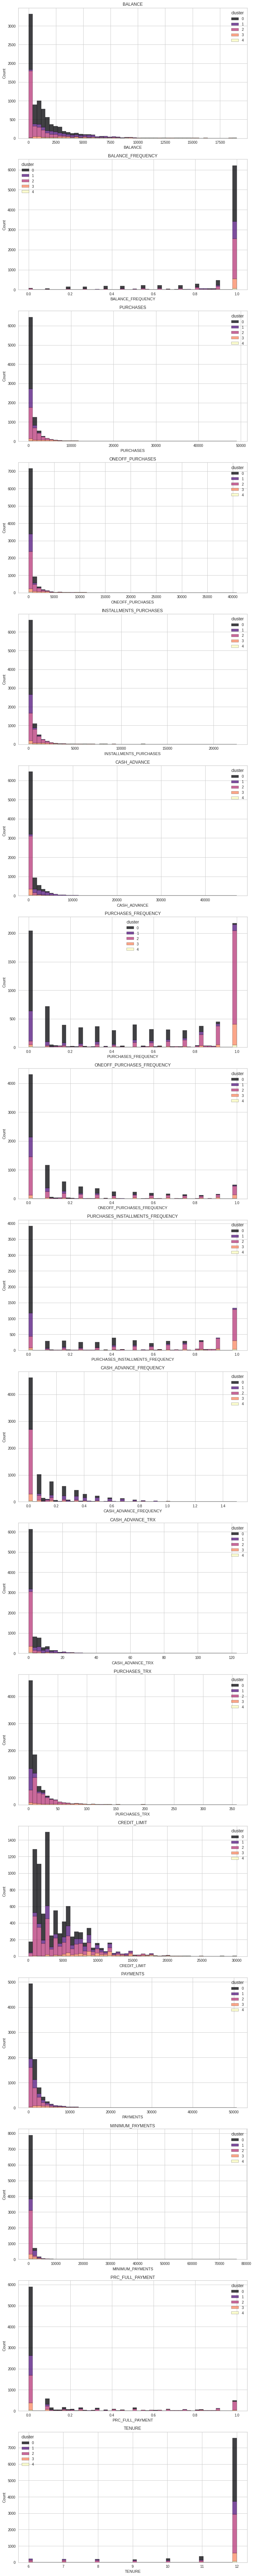

In [ ]:
plt.figure(figsize=(10,100))
for i in range(num_columns):
    plt.subplot(17, 1, i+1)
    sns.histplot(data = df_cluster_autoencoded, x = df_credit.columns[i], hue = 'cluster', multiple = 'stack', palette = sns.color_palette("magma", as_cmap=True),bins = 50)
    #sns.kdeplot(data = df_credit, x = df_credit.columns[i], color = 'b', lw = 3)
    plt.title(df_credit.columns[i])
plt.tight_layout()

In [ ]:
pca = PCA(n_components=2, random_state=SEED)
prin_comp = pca.fit_transform(pred)
pca_df_2 = pd.DataFrame(data = prin_comp, columns =['pca1','pca2'])
pca_df_2.head()

,pca1,pca2
0,-3.524541,-0.154277
1,-0.004741,2.327760
2,0.095119,-0.406280
3,-2.519399,0.182201
4,-3.602459,0.091797


In [ ]:
pca_df_2 = pd.concat([pca_df_2,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df_2.head()

,pca1,pca2,cluster
0,-3.524541,-0.154277,0
1,-0.004741,2.327760,1
2,0.095119,-0.406280,2
3,-2.519399,0.182201,0
4,-3.602459,0.091797,0


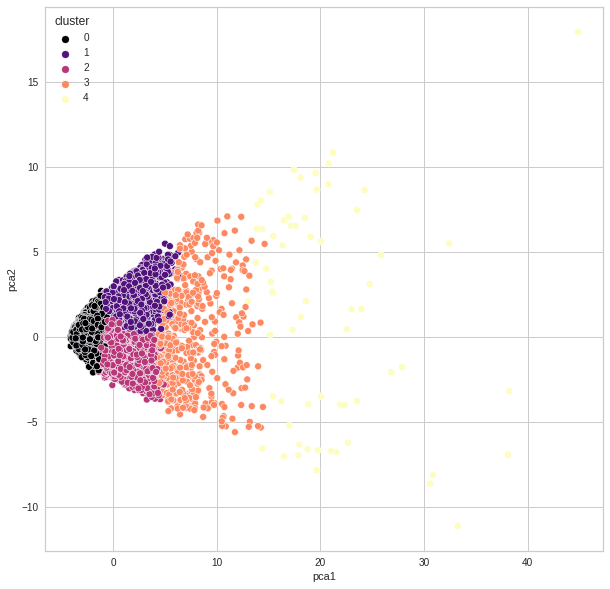

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df_2, palette =sns.color_palette("magma", as_cmap=True))
plt.show()